# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')
%matplotlib inline

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

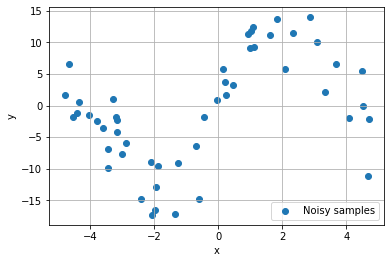

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

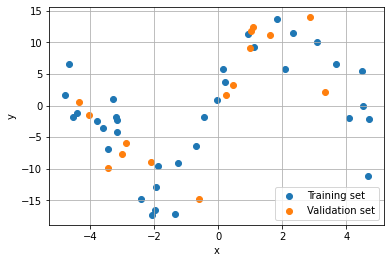

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None, poly_features=None):
    
    if poly_features:
        preprocessor = ColumnTransformer(
                        remainder='passthrough',
                        transformers=[
                            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0)), poly_features)
                        ])
    else:
        preprocessor = PolynomialFeatures(degree, include_bias=(degree == 0))
        
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000) 
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000)     
    return Pipeline([
        ('pol', preprocessor),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

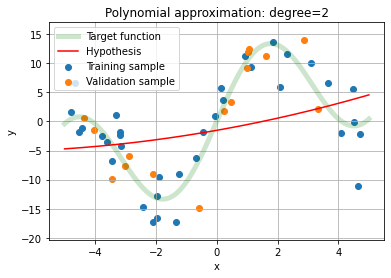

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

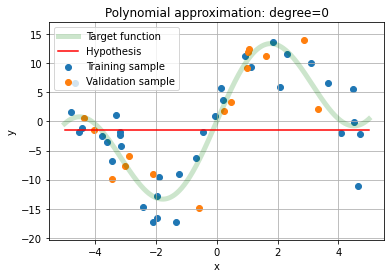

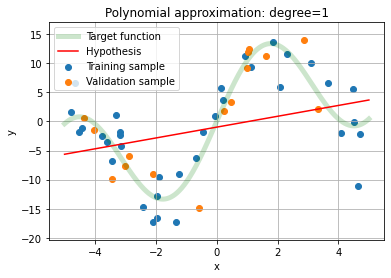

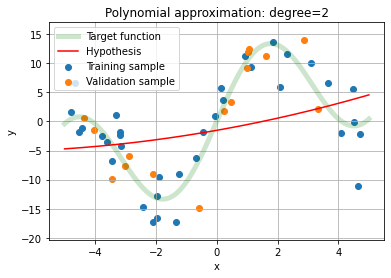

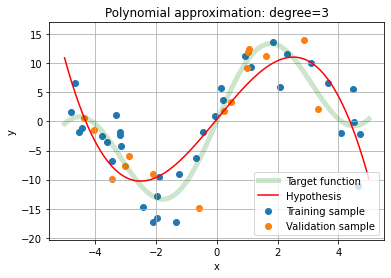

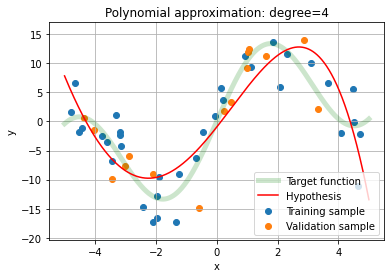

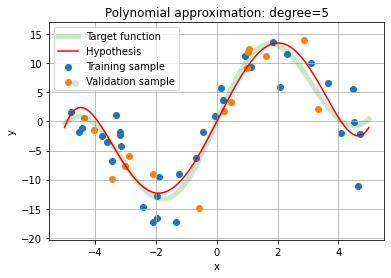

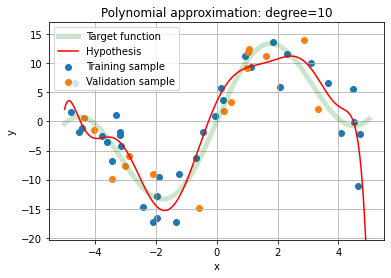

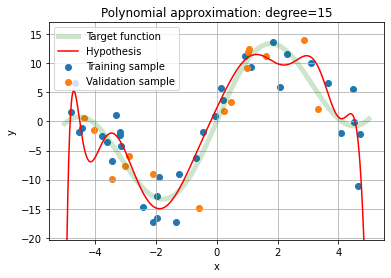

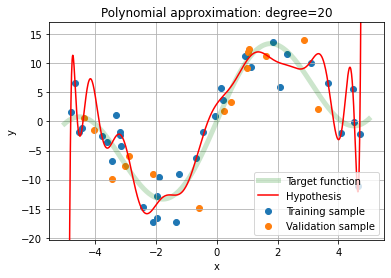

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

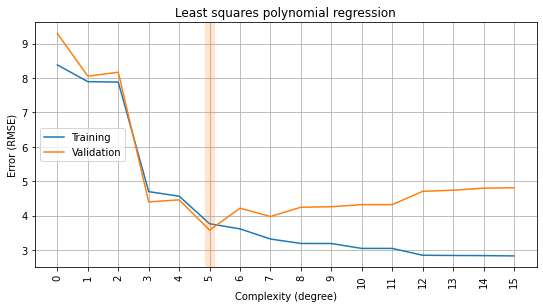

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

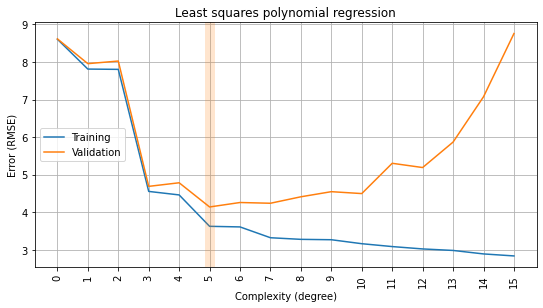

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

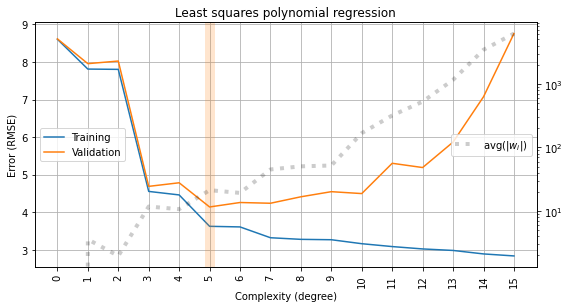

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

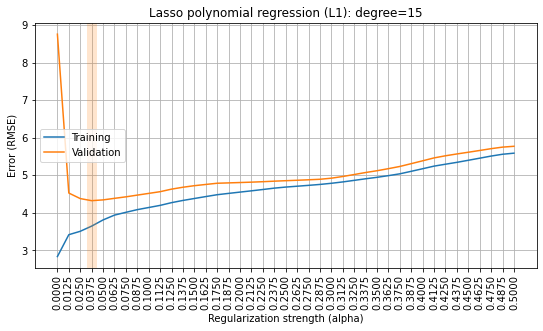

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

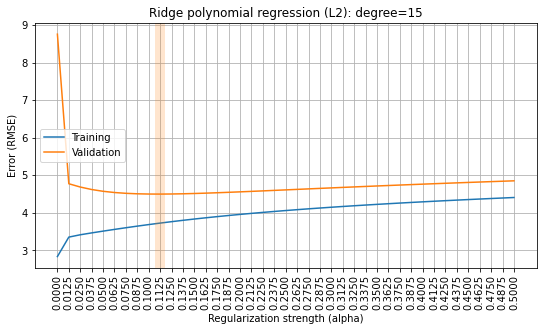

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

**WARNING!**

   Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
X_diabetes.sample(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
291,0.074401,-0.044642,0.018584,0.063187,0.061725,0.042840,0.008142,-0.002592,0.058039,-0.059067
365,0.034443,-0.044642,-0.038540,-0.012556,0.009439,0.005262,-0.006584,-0.002592,0.031193,0.098333
221,-0.045472,-0.044642,-0.038540,-0.026328,-0.015328,0.000878,-0.032356,-0.002592,0.001144,-0.038357


In [22]:
X_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


In [23]:
X_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


Исследуем и, по возможности, понизим формат данных (что уменьшит размер данных в байтах и оптимизирует скорость выполнение кода)

In [24]:
#характеристики возможных типов
float_types = ["float16", "float32", "float64"]
for fl in float_types:
    print(np.finfo(fl))

Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   e

In [25]:
#накопленная абсолютная разность (потеря точности) модулей
cum_abs_diff = abs(abs(X_diabetes) - abs(X_diabetes.astype('float16'))).sum()
cum_abs_diff

age    0.002490
sex    0.003294
bmi    0.002940
bp     0.002773
s1     0.003079
s2     0.003030
s3     0.002796
s4     0.002876
s5     0.003221
s6     0.002879
dtype: float64

In [26]:
#средняя абсолютная ошибка (потеря точности)
cum_abs_diff/X_diabetes.shape[0]

age    0.000006
sex    0.000007
bmi    0.000007
bp     0.000006
s1     0.000007
s2     0.000007
s3     0.000006
s4     0.000007
s5     0.000007
s6     0.000007
dtype: float64

In [27]:
#норма (корень суммы квадратов разниц)
(X_diabetes - X_diabetes.astype('float16')).apply(np.linalg.norm)

age    0.000185
sex    0.000162
bmi    0.000206
bp     0.000187
s1     0.000219
s2     0.000222
s3     0.000193
s4     0.000208
s5     0.000222
s6     0.000206
dtype: float64

In [28]:
#отключим экспоненциальную запись 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#разница абсолютных характеристик
abs(X_diabetes.describe())-abs(X_diabetes.astype('float16').describe())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
std,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
min,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000
25%,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000
50%,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
75%,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000
max,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000


In [29]:
#включим экспоненциальную запись
pd.set_option('display.float_format', None)

в вышепроведенном исследовании видно, что потеря точности при downcast (понижающем пробразовании) в формат 'float16' составляет не более 3-х знаков после запятой, что, наверное, не критично для данного задания, и, поэтому, применим downcast

In [30]:
X_diabetes = X_diabetes.astype('float16')
X_diabetes[:3]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038086,0.050690,0.061707,0.021866,-0.044220,-0.034821,-0.043396,-0.002592,0.019913,-0.017639
1,-0.001882,-0.044647,-0.051483,-0.026321,-0.008446,-0.019165,0.074402,-0.039490,-0.068359,-0.092224
2,0.085327,0.050690,0.044464,-0.005672,-0.045593,-0.034180,-0.032349,-0.002592,0.002863,-0.025925


In [31]:
X_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float16
 1   sex     442 non-null    float16
 2   bmi     442 non-null    float16
 3   bp      442 non-null    float16
 4   s1      442 non-null    float16
 5   s2      442 non-null    float16
 6   s3      442 non-null    float16
 7   s4      442 non-null    float16
 8   s5      442 non-null    float16
 9   s6      442 non-null    float16
dtypes: float16(10)
memory usage: 8.8 KB


- после downcast размер данных (memory usage) уменьшился почти в 4 раза (с первичных 34,7 кб до 8,8 кб)

выполним преобразование формата для таргета

In [32]:
y_diabetes.sample(3)

,target
162,172.0
310,109.0
51,225.0


In [33]:
y_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  442 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB


In [34]:
y_diabetes.describe()

,target
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


- скорее всего, весь таргет - целые числа

In [35]:
#характеристики интов
int_types = ["uint8", "int8", "int16", "uint16"] 
for it in int_types: 
    print(np.iinfo(it)) 

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------



In [36]:
(abs(y_diabetes) - abs(y_diabetes.astype('uint16'))).sum()

target    0.0
dtype: float64

- при преобразовании в 'uint16' нет потери точности, поэтому преобразуем

In [37]:
y_diabetes = y_diabetes.astype('uint16')
y_diabetes.sample(3)

,target
402,168
206,196
325,192


In [38]:
y_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  442 non-null    uint16
dtypes: uint16(1)
memory usage: 1012.0 bytes


- выберем несколько признаков для полиномизации

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.1,\
                                                      random_state=SEED)

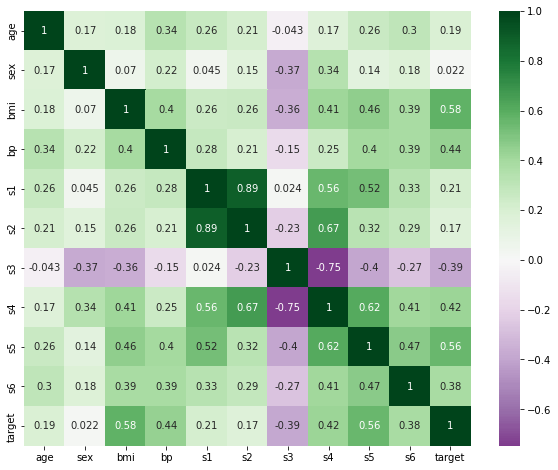

In [40]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), annot=True, center=0, cmap='PRGn')

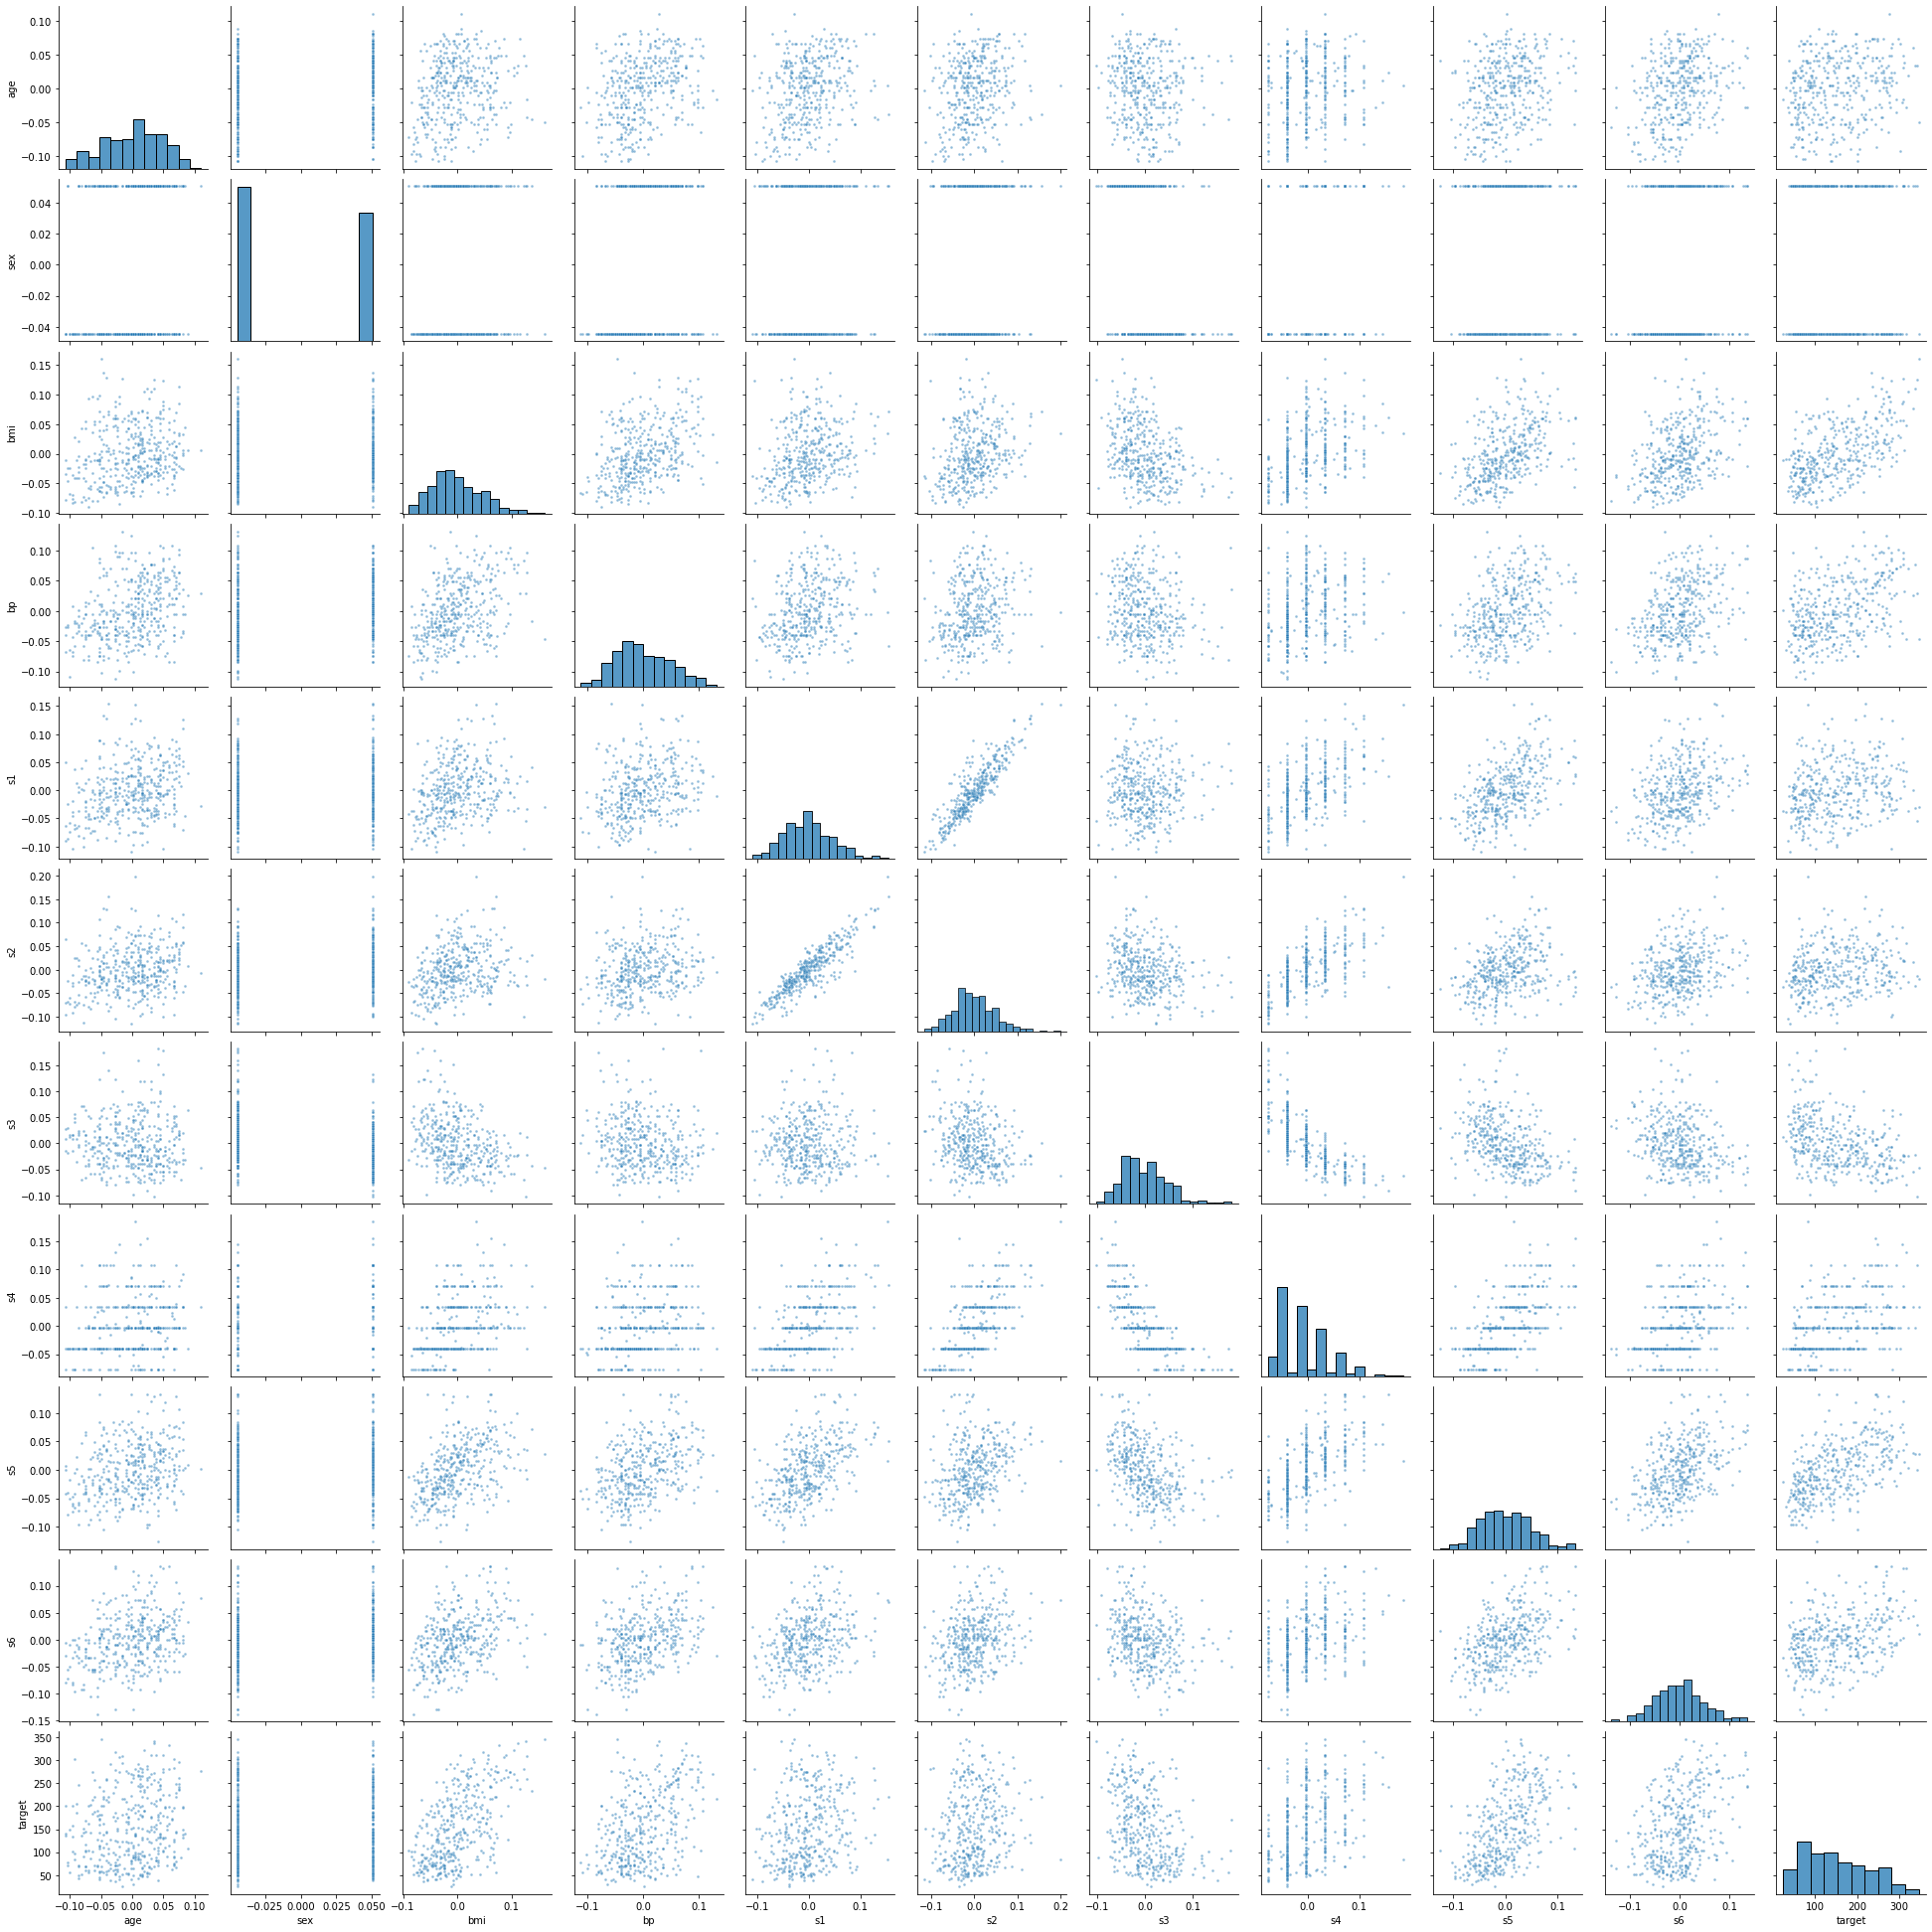

In [41]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), plot_kws={'s': 7, 'alpha': 0.5});

- явных нелинейных зависимостей не видно, поэтому, возьмем, например, age, bp, s6

In [42]:
POLYNOM_FEATURES = ['age', 's1', 's6']
DEGREES_ = DEGREES[1:]

In [43]:
make_model(1, poly_features=POLYNOM_FEATURES).fit(X_train, y_train)

Pipeline(steps=[('pol',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pol',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  ['age', 's1', 's6'])])),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

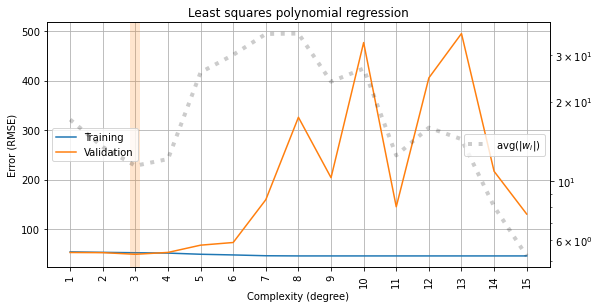

In [44]:
# для сравнения, переберем степени без кросс-валидации
rmse_train, rmse_valid, avg_coef = [], [], []
coefs=[]
for degree in DEGREES_:
    reg = make_model(degree, poly_features=POLYNOM_FEATURES).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    coef = reg['reg'].coef_
    coefs.append(coef)
    avg_coef.append(np.mean(np.abs(coef)))              
    
plot_fitting_graph(DEGREES_, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

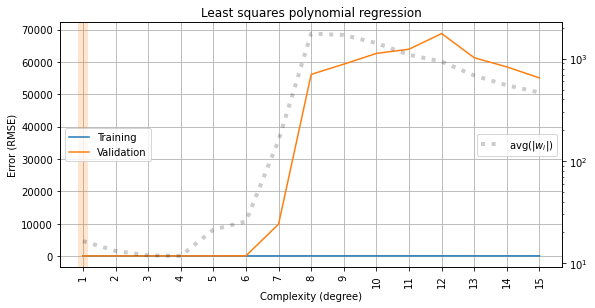

In [45]:
# cross_validate
rmse_train, rmse_valid, avg_coef = [], [], []

for degree in DEGREES_:
    results = cross_validate(make_model(degree, poly_features=POLYNOM_FEATURES),
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES_, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

- в варианте без кросс-валидации лучшей является 3-тья степень признаков, с кросс-валидацией - 1-ая степень, что наглядно показывает разность подходов и неоднородность тестовой выборки и валидационной

- при увеличении степени полниомиризации возрастают коэффиценты, так как возрастает коллинеарность

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.312e+02, tolerance: 2.156e+02
  model = cd_fast.enet_coordinate_descent(
j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+03, tolerance: 2.051e+02
  model = cd_fast.enet_coordinate_descent(


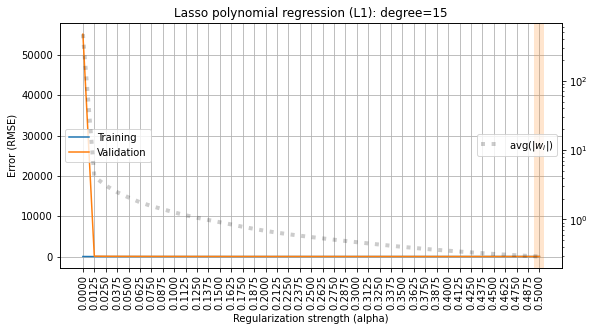

In [46]:
## your code
def regul(penalty='L1', poly_features=None):
    rmse_train, rmse_valid, avg_coef = [], [], []
    abs_coefs = []
    for alpha in ALPHAS:    
        results = cross_validate(make_model(degree=15, poly_features=poly_features, 
                                            penalty=penalty, alpha=alpha), 
                                 X_diabetes, y_diabetes, cv=5,
                                 return_train_score=True, return_estimator=True,
                                 scoring='neg_root_mean_squared_error')
        rmse_train.append(-np.mean(results['train_score']))
        rmse_valid.append(-np.mean(results['test_score']))
        abs_coef = [            
                # mean absolute value of weights
                np.abs(model['reg'].coef_)
                for model in results['estimator']
            ]
        
        abs_coefs.append(abs_coef)
        avg_coef.append(np.mean(np.mean(abs_coef)))

    plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                       xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                       custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                       title=f'Lasso polynomial regression ({penalty}): degree=15')

    return abs_coefs

L1_abs_coefs = regul(poly_features=POLYNOM_FEATURES)

#### L2

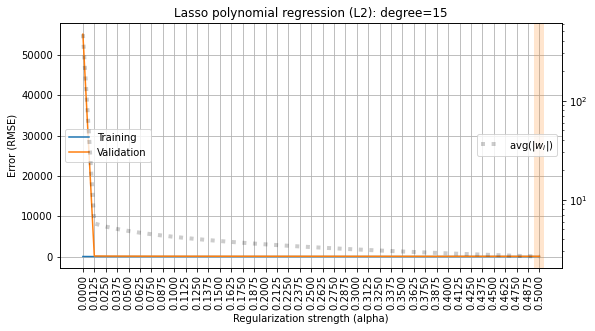

In [47]:
# your code
L2_abs_coefs = regul(penalty='L2', poly_features=POLYNOM_FEATURES)

#### Summary

- применение регуляризации L1 и L2 наглядно показывает , что методы регуляризации ограничивают коэффициенты (пунктирная линия)

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [48]:
## your code
def plot_zero(y):
    plt.plot(ALPHAS, [100*(np.ravel(x).size-np.count_nonzero(x)) / np.ravel(x).size for x in y],
             label='Percent zero coefficients')
    plt.grid(True)
    plt.xlabel('Regularization strength (alpha)')
    plt.ylabel('%')
    plt.legend(loc='best')    
    plt.title(f'Zero coefficients: degree=15 and alpha from ALPHAS')
    plt.show()

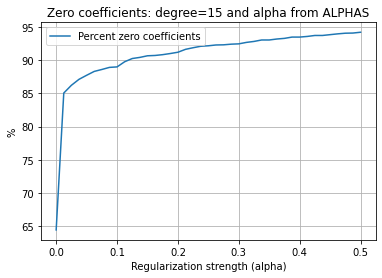

In [49]:
plot_zero(L1_abs_coefs)

#### L2

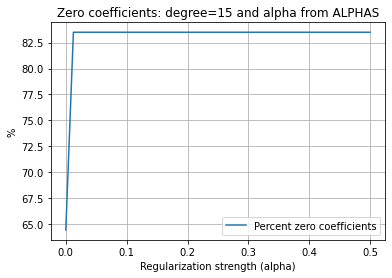

In [50]:
## your code
plot_zero(L2_abs_coefs)

#### Summary

- из графиков видно, что после применения регуляризации L1 становится больше нулевых коэффициентов, а так же их количество увеличивается при увеличении alpha 

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [51]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [52]:
def regul_hw(penalty, X_hw, y_hw):
    
    X_train_hw, X_valid_hw, y_train_hw, y_valid_hw = train_test_split(X_hw, y_hw, test_size=0.3,\
                                                      random_state=SEED)
    rmse_train, rmse_valid, avg_coef = [], [], []
    coefs=[]
    
    for alpha in ALPHAS:
        if penalty == 'L1':
            reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train_hw, y_train_hw)
        elif penalty == 'L2':
            reg = Ridge(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train_hw, y_train_hw)
        rmse_train.append(rmse(reg.predict(X_train_hw), y_train_hw))
        rmse_valid.append(rmse(reg.predict(X_valid_hw), y_valid_hw))
        coef = reg.coef_
        coefs.append(coef)
        avg_coef.append(np.mean(np.abs(coef)))         

    plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, xlabel='Regularization strength (alpha)', 
                       ylabel='Error (RMSE)', 
                       custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                       title=f'Least squares {penalty} regression')
    return np.abs(coefs).mean(axis=0)

#### L1

<ipython-input-52-5ae7510f34fd>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train_hw, y_train_hw)
j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 1.685e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

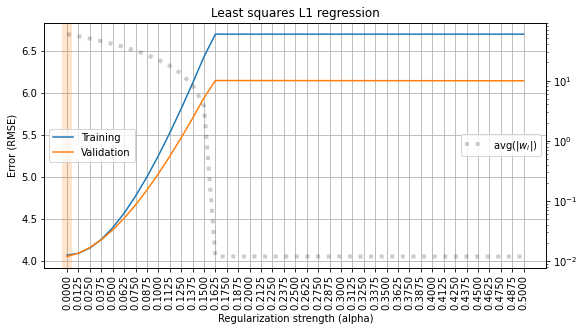

In [53]:
L1_avg_coef = regul_hw(penalty='L1', X_hw=X_hw, y_hw=y_hw)

In [54]:
# проведем масштабирование данных
X_hw_sca = StandardScaler().fit_transform(X_hw)
for i in range(X_hw_sca.shape[1]):
    print(f'Min of feature {i}: {min(X_hw_sca[:, i]):.2f}, max: {max(X_hw_sca[:, i]):.2f}')

Min of feature 0: -1.49, max: 1.83
Min of feature 1: -1.66, max: 1.54
Min of feature 2: -2.14, max: 2.24


<ipython-input-52-5ae7510f34fd>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = Lasso(alpha=alpha, random_state=SEED, max_iter=50000).fit(X_train_hw, y_train_hw)
j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
j:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.903e+02, tolerance: 1.685e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

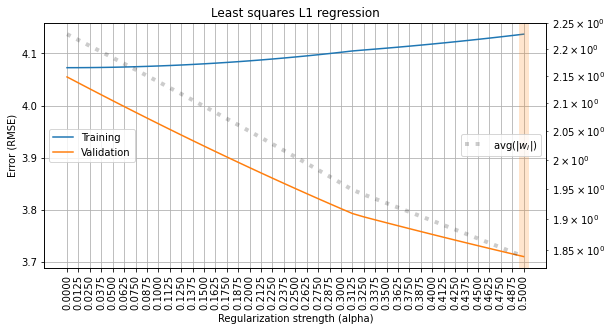

In [55]:
L1_avg_coef_SCA = regul_hw(penalty='L1', X_hw=X_hw_sca, y_hw=y_hw)

In [56]:
# средние абсолютные коэффициенты без масштабирования
L1_avg_coef

array([2.97829113e+01, 1.37582576e-03, 3.31292041e-02])

In [57]:
# c масштабированием
L1_avg_coef_SCA

array([4.84460859, 0.1027169 , 1.10194368])

#### L2

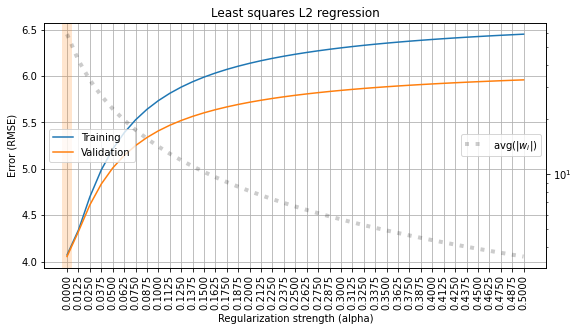

In [58]:
L2_avg_coef = regul_hw(penalty='L2', X_hw=X_hw, y_hw=y_hw)

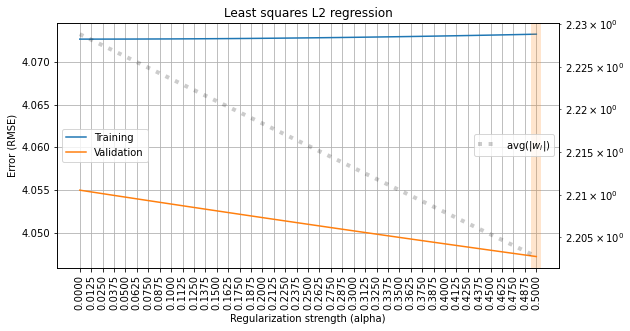

In [59]:
# с масштабированием
L2_avg_coef_SCA = regul_hw(penalty='L2', X_hw=X_hw_sca, y_hw=y_hw)

In [60]:
# средние абсолютные коэффициенты без масштабирования
L2_avg_coef

array([3.32613632e+01, 1.36981574e-03, 3.30739122e-02])

In [61]:
# с масштабированием
L2_avg_coef_SCA

array([5.01618965, 0.32028849, 1.31077057])

#### Summary



- до стандартизации данные имеют разные масштабы, из-за чего возникает большая разница между коэффициентами и возрастает ошибка RSME
- Вывод: стандартизация позволяет привести данные к соответствующим масштабам и увеличить точность предсказания